# Introduction

This notebook contains a guide on how to train, validate and test the models from the paper on a given data set. In the following, we resort to the simplest, and computationally most efficient example, such that the code can be easily tested on your local machine before running large scale training on a cluster. 

In [3]:
# Do the imports that we need along the way.
import e3x
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pathlib

from euclidean_fast_attention import NpzTrainer
from euclidean_fast_attention import EnergyModel

## Loading the Data

We start by loading the data set that we want to use for training, validation and testing of the trained model.

In [84]:
# maximal number of graphs, nodes and edges per batch. This must be adapted for chosen accordingly when 
# going to larger molecules.

avg_number_of_nodes_per_graph = 2  # all graphs consist of two atoms.

max_num_graphs = 10
max_num_nodes = max_num_graphs * avg_number_of_nodes_per_graph + 1

# node that this assumes a fully connected graph, which is 
# not neccessary when the local cutoff is smaller than the largest atomic seperation.
max_num_edges = max_num_graphs * (avg_number_of_nodes_per_graph * (avg_number_of_nodes_per_graph - 1)) + 1

# For details on batching graphs see https://jraph.readthedocs.io/en/latest/api.html#batching-padding-utilities

npztrainer = NpzTrainer(
    data_dir=(
        pathlib.Path(f'../datasets/two_atoms.npz').expanduser().resolve()
    ),
    num_train=2000,
    num_valid=500,
    num_epochs=500,
    max_num_nodes=max_num_nodes,
    max_num_edges=max_num_edges,
    max_num_graphs=max_num_graphs,
    energy_unit=1.,
    length_unit=1.,
    save_interval_steps=250,  # Every 250 iterations the model is validated on the validation set and validation error is logged.
    log_interval_steps=10_000,  # Log the training error every 10.000 steps.
    use_wandb=False
)

## Model Initialization

Next, we initialize an MPNN model with `model_nl` and without `model_l` EFA block.  

In [85]:
# Number of layers to use.
num_layers = 2

# Message passing cutoff.
mp_cutoff = 5.

# Features dimension of the representations.
num_features = 64

# In which layers use EFA.
efa_use_in_iterations = [0, 1]

# Feature dimension of the query and key in EFA.
efa_qk_num_features=32

# Feature dimension of the value in EFA.
efa_v_num_features=16

# Maximal atomic separation in the dataset
max_length = 10.

# Maximal degree in MP update
mp_max_degree = 0

# A local O3 equivariant MPNN with EFA block.
model_nl = EnergyModel(
    cutoff=mp_cutoff,
    mp_max_degree=mp_max_degree,
    num_features=num_features,
    num_iterations=num_layers,
    era_use_in_iterations=efa_use_in_iterations,
    era_lebedev_num=50,
    era_include_pseudotensors=False,
    era_max_degree=0,
    era_qk_num_features=efa_qk_num_features,
    era_v_num_features=efa_v_num_features,
    era_max_frequency=jnp.pi,
    era_max_length=max_length,
    atomic_dipole_embedding=False,
    era_activation_fn=e3x.nn.gelu,
    era_tensor_integration=False,
    era_ti_max_degree_sph=None,
    era_ti_max_degree=None,
    era_ti_parametrize_coupling_paths=False,
    era_ti_degree_scaling_constants=None,
    output_is_zero_at_init=False
)

# A standard local O3 equivariant MPNN.
model_l = EnergyModel(
    num_iterations=num_layers, 
    num_features=num_features,
    mp_max_degree=mp_max_degree,
    era_use_in_iterations=None
)

In [ ]:
# Training of the model with EFA

# Specify some location where the checkpoints should be saved. 
ckpt_dir_nl = pathlib.Path('test_run_nl').expanduser().resolve()  # Checkpoint path must be absolute

learning_rate = 1e-3

# Initialize the learning rate schedule.
schedule = optax.exponential_decay(
    init_value=learning_rate,
    transition_steps=int(
        npztrainer.num_train
        / (npztrainer.max_num_graphs - 1)
        * npztrainer.num_epochs
    ),
    decay_rate=1e-5 / learning_rate,
)

# Initialize optimizer.
optimizer = optax.adam(learning_rate=schedule)

# Train the model.
_ = npztrainer.run_training(model_nl, optimizer, ckpt_dir=ckpt_dir_nl)

In [ ]:
# Training of the same model without EFA

# Specify some location where the checkpoints should be saved. 
ckpt_dir_l = pathlib.Path('test_run_l').expanduser().resolve()  # Checkpoint path must be absolute

learning_rate = 1e-3

# Initialize the learning rate schedule.
schedule = optax.exponential_decay(
    init_value=learning_rate,
    transition_steps=int(
        npztrainer.num_train
        / (npztrainer.max_num_graphs - 1)
        * npztrainer.num_epochs
    ),
    decay_rate=1e-5 / learning_rate,
)

# Initialize optimizer.
optimizer = optax.adam(learning_rate=schedule)

# Train the model.
_ = npztrainer.run_training(model_l, optimizer, ckpt_dir=ckpt_dir_l)

# Loading from Checkpoint and Simple Energy Scan

After trainign we can load the checkpoint from the `ckpt_dir`. 

**Please note: When you trained on GPU and aim to load on your local machine without GPU, you have to manually remove the `_sharding` file from the `params` and `opt_state` directory in the directory `ckpt_XXX` which can be found in the specified `ckpt_dir`.**

In [99]:
import orbax.checkpoint as ocp
import pathlib

def load_params(ckpt_dir):
    loaded_mngr = ocp.CheckpointManager(
        pathlib.Path(ckpt_dir).expanduser().absolute().resolve(),
        item_names=('params', 'opt_state'),
        item_handlers={
            'params': ocp.StandardCheckpointHandler(),
            'opt_state': ocp.StandardCheckpointHandler(),
        },
        options=ocp.CheckpointManagerOptions(step_prefix="ckpt"),
    )
    restored = loaded_mngr.restore(
        loaded_mngr.latest_step(),
        args=None
    )

    return restored['params']

In [100]:
params_nl = load_params(ckpt_dir_nl)

metrics_nl, (energy_pred_nl, forces_pred_nl, energy_true_nl, forces_true_nl, test_graphs_nl) = npztrainer.run_testing(
    params=params_nl,
    model=model_nl,
    num_test=200,
    collect_predictions=True,
    max_num_graphs=2,  # by only having two graphs per batch (one real graph and one padding graph) this allows to recover the pairwise distances in the next step easily
    max_num_nodes=3,
    max_num_edges=3
)

Stop testing after n=199 batches since 200 test structures have been reached.
Metrics are collected from 200 test structures.


In [101]:
params_l = load_params(ckpt_dir_l)

metrics_l, (energy_pred_l, forces_pred_l, energy_true_l, forces_true_l, test_graphs_l) = npztrainer.run_testing(
    params=params_l,
    model=model_l,
    num_test=200,
    collect_predictions=True,
    max_num_graphs=2,  # by only having two graphs per batch (one real graph and one padding graph) this allows to recover the pairwise distances in the next step easily
    max_num_nodes=3,
    max_num_edges=3
)

Stop testing after n=199 batches since 200 test structures have been reached.
Metrics are collected from 200 test structures.


In [102]:
# Print the error on 200 samples from the test set

print('Metric EFA augmented model')
print(metrics_nl)

print('Metric local model')
print(metrics_l)

Metric EFA augmented model
{'energy_mae': 0.0005459861131384969, 'energy_mse': 3.5198439718442387e-07, 'energy_rmse': 0.0005932827480137348, 'forces_mae': 0.000508697412442416, 'forces_mse': 1.8256611156175495e-06, 'forces_rmse': 0.0013511702418327332}
Metric local model
{'energy_mae': 0.04211229085922241, 'energy_mse': 0.0020976990927010775, 'energy_rmse': 0.045800644904375076, 'forces_mae': 0.007669136393815279, 'forces_mse': 0.0001179372047772631, 'forces_rmse': 0.010859889909625053}


In [103]:
# We need to remove the padded graphs and padding predictions for energies and forces

distances_nl = []
energies_pred_nl = []
energies_true_nl = []

for g, ep, et in zip(test_graphs_nl, energy_pred_nl, energy_true_nl):
    # Using the fact that there are only two atom (one graph) per batch
    dij = np.linalg.norm(g.nodes['positions'][0] - g.nodes['positions'][1], axis=-1)
    distances_nl.append(dij)
    
    graph_mask = jraph.get_graph_padding_mask(g)
    energies_pred_nl.append(ep[graph_mask])
    energies_true_nl.append(et[graph_mask])

energies_pred_nl = np.stack(energies_pred_nl)
energies_true_nl = np.stack(energies_true_nl)
distances_nl = np.stack(distances_nl, axis=0)

In [104]:
# We need to remove the padded graphs and padding predictions for energies and forces

distances_l = []
energies_pred_l = []
energies_true_l = []

for g, ep, et in zip(test_graphs_l, energy_pred_l, energy_true_l):
    # Using the fact that there are only two atom (one graph) per batch
    dij = np.linalg.norm(g.nodes['positions'][0] - g.nodes['positions'][1], axis=-1)
    distances_l.append(dij)
    
    graph_mask = jraph.get_graph_padding_mask(g)
    energies_pred_l.append(ep[graph_mask])
    energies_true_l.append(et[graph_mask])

energies_pred_l = np.stack(energies_pred_l)
energies_true_l = np.stack(energies_true_l)
distances_l = np.stack(distances_l, axis=0)

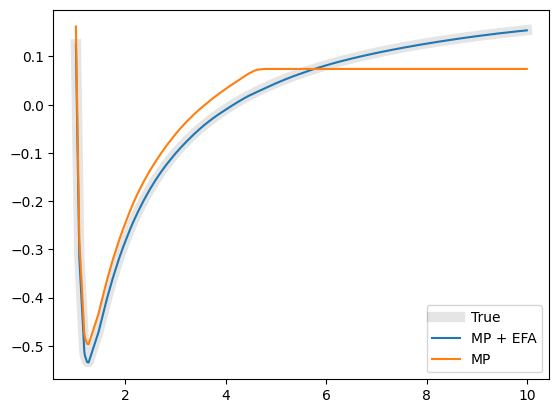

In [105]:
import matplotlib.pyplot as plt
sort_idx = np.argsort(distances_l)  # is the same for _l and _nl

# This reproduces the curve in Fig. 1B
plt.plot(distances_l[sort_idx], energies_true_nl[sort_idx], lw=7.5, c='k', alpha=0.1, label='True')
plt.plot(distances_nl[sort_idx], energies_pred_nl[sort_idx], label='MP + EFA')
plt.plot(distances_l[sort_idx], energies_pred_l[sort_idx], label='MP')

plt.legend()